In [1]:
# import event simulation files
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math
import matplotlib.pyplot as plt
import csv

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import snntorch as snn
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
import snntorch.functional as SF

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Selected device is',device)

Selected device is cpu


/home/andrea/anaconda3/envs/torch/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449229234/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Data processing

In [19]:
n_evt = 100000
n_evt_test = 10000
n_evt_val = 10000

evt_arr,      muon_list,      max_n      = ge.generate_noisy_evts(n_evt,      noise_frac=0.5, bkg_frac=0.3)
evt_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(n_evt_test, noise_frac=0.5, bkg_frac=0.3)
evt_arr_val,  muon_list_val,  max_n_val  = ge.generate_noisy_evts(n_evt_val,  noise_frac=0.5, bkg_frac=0.3)

100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1189.91it/s]


In [20]:
# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype, features):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return torch.tensor(padded_array)

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
mu_arr      = convert_to(muon_list,      size=max_n,      target_dtype=np.float32, features=feature_list)
mu_arr_test = convert_to(muon_list_test, size=max_n_test, target_dtype=np.float32, features=feature_list)
mu_arr_val  = convert_to(muon_list_val,  size=max_n_val,  target_dtype=np.float32, features=feature_list)

In [21]:
def custom_spikegen(data, num_step=40, batch_size=100, linearise=True):

    spike_data = torch.zeros(size=(num_step, batch_size, ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    for n_batch, evt in enumerate(data):
        for hit in evt:
            layer = int(hit[0])
            wire = int(hit[1])
            bx = int(hit[2])
            t0 = math.floor(hit[3])
            if bx != 0:
                spike_data[bx-t0+ps.bx_oot, n_batch, layer-1, wire-1] = 1
            else:
                break
    if linearise:
        spike_data = spike_data.view(num_step, batch_size, -1)
                
    return spike_data    

In [22]:
def gen_target_chamber(muon_list):
    target = np.zeros(shape=(len(muon_list)))
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            if hit['signal'] == True:
                target[i] = 1
                break

    return torch.tensor(target, dtype=torch.long)

In [23]:
def filter_noise(muon_list):
    target_list=[]
    
    for event in muon_list:
        target_event=[]
        for hit in event:
            
            if hit["signal"] == True:
                target_event.append(hit)
        
        target_list.append(target_event)
        
    return target_list

def gen_target_timing(muon_list, size, target_dtype, features):
    filtered_list = filter_noise(muon_list)
    return convert_to(filtered_list, size, target_dtype, features)

In [24]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.data = list(zip(input_data, target))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


# Transformations

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    if type(input_variable) != torch.Tensor:
        input_variable = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = input_variable.to(target_dtype)
    
    return tensor


transform = transforms.Compose([
    lambda x: (to_tensor_and_dtype(x[0], target_dtype=torch.float32), x[1])
])

In [25]:
target      = gen_target_chamber(muon_list)
target_test = gen_target_chamber(muon_list_test)
target_val  = gen_target_chamber(muon_list_val)

train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=nw)

100000it [00:00, 1181197.95it/s]
10000it [00:00, 1222365.87it/s]
10000it [00:00, 558957.33it/s]


## LSTM

In [26]:
class Net1layer2ndOrder(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps,learnable,alpha,beta,threshold):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.beta=beta
        self.threshold=threshold
        self.alpha=alpha
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=self.beta,alpha=self.alpha,threshold=self.threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=self.beta,alpha=self.alpha,threshold=self.threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            
            cur1f = self.fc_in(x[step])
            cur1i = self.fc_in(x[step])
            
            spk1f, syn1f, mem1f = self.lif_in(cur1f, syn1f, mem1f)
            spk1i, syn1i, mem1i = self.lif_in(cur1i, syn1i, mem1i)
            
            cur1g = self.fc_in(x[step])
            
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [31]:
# Network Architecture 5
num_inputs5 = ps.NLAYERS*ps.NWIRES
num_hidden5 = 100
num_outputs_chamber5 = 2

num_steps5 = 40
beta5 = 0.8
alpha5 =0.8
threshold5=1

net  = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_chamber5, num_steps5,False,alpha5,beta5,threshold5).to(device)

In [32]:
loss_hist = []
loss_val_hist = []
acc_val_hist = []

iter_counter = 0
num_steps=40
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3, betas=(0.9, 0.999))

for epoch in range(num_epochs):
    net.train()
    batch_counter = 0
    # Minibatch training loop
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
            
        # create spike train
        spike_in = custom_spikegen(data, num_steps, batch_size, True).to(device)

        # forward pass
        spk_rec, mem_rec = net(spike_in)
        output = mem_rec

        # compute loss
        loss_val = torch.zeros((1), device=device)
        for step in range(num_steps):
            loss_val += loss(output[step], targets)
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:", epoch)
            print("Batch:", batch_counter)
            print("Iteration:", iter_counter)
            print("Loss:", loss_val.item(),"\n")
        
        batch_counter += 1
        iter_counter += 1

Epoch: 0
Batch: 0
Iteration: 0
Loss: 23.642332077026367 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 21.480403900146484 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 16.570079803466797 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 17.937803268432617 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 16.743051528930664 



KeyboardInterrupt: 

## Network definitions

In [10]:
# Network Architecture 1
num_inputs1 = ps.NLAYERS*ps.NWIRES
num_hidden1 = 100
num_outputs_chamber1 = 2

num_steps1 = 40
beta1 = 0.8
threshold1=0.9

# Network Architecture 2
num_inputs2 = ps.NLAYERS*ps.NWIRES
num_hidden2 = [20,20,20]
num_outputs_chamber2 = 2

num_steps2 = 40
beta2 = 0.8
alpha2 =0.8
threshold2=0.9

# Network Architecture 3
num_inputs3 = ps.NLAYERS*ps.NWIRES
num_hidden3 = 30
num_outputs_chamber3 = 2

num_steps3 = 40
beta3 = 0.8
threshold3=0.9

# Network Architecture 4
num_inputs4 = ps.NLAYERS*ps.NWIRES
num_hidden4 = 100
num_outputs_chamber4 = 2

num_steps4 = 40
beta4 = 0.5
threshold4=0.9

# Network Architecture 5
num_inputs5 = ps.NLAYERS*ps.NWIRES
num_hidden5 = 100
num_outputs_chamber5 = 2

num_steps5 = 40
beta5 = 0.8
alpha5 =0.8
threshold5=0.9

# Network Architecture 6
num_inputs6 = ps.NLAYERS*ps.NWIRES
num_hidden6 = 30
num_outputs_chamber6 = 2

num_steps6 = 40
beta6 = 0.5
threshold6=0.9

In [12]:
class Net1layer(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps,learnable,beta,threshold):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.beta=beta
        self.threshold=threshold
        
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=self.beta,spike_grad=spike_grad,threshold=self.threshold,
                                learn_beta=learnable,learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=self.beta,spike_grad=spike_grad,threshold=self.threshold,
                                learn_beta=learnable,learn_threshold=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [13]:
class Net1layer2ndOrder(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps,learnable,alpha,beta,threshold):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.beta=beta
        self.threshold=threshold
        self.alpha=alpha
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=self.beta,alpha=self.alpha,threshold=self.threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=self.beta,alpha=self.alpha,threshold=self.threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [14]:
class Net3layers(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps,learnable,alpha,beta,threshold):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.beta=beta
        self.threshold=threshold
        self.alpha=alpha
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden[0])
        self.lif_in = snn.Synaptic(beta=  self.beta,alpha=self.alpha,
                                   spike_grad=spike_grad,
                                   threshold=self.threshold,
                                  learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_hidden1 = nn.Linear(in_features=self.hidden[0], out_features=self.hidden[1])
        self.lif_hidden1 = snn.Synaptic(beta=  self.beta,alpha=self.alpha,
                                    spike_grad=spike_grad,
                                    threshold=self.threshold,
                                       learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_hidden2 = nn.Linear(in_features=self.hidden[1], out_features=self.hidden[2])
        self.lif_hidden2 = snn.Synaptic(beta=  self.beta,alpha=self.alpha,
                                    spike_grad=spike_grad,
                                    threshold=self.threshold,
                                       learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden[2], out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=  self.beta,alpha=self.alpha,
                                    spike_grad=spike_grad,
                                    threshold=self.threshold,
                                   learn_beta=learnable,learn_threshold=learnable,learn_alpha=learnable)
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        synh1, memh1 = self.lif_hidden1.init_synaptic()
        synh2, memh2 = self.lif_hidden2.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            curh1 = self.fc_hidden1(spk1)
            spkh1, synh1, memh1 = self.lif_hidden1(curh1, synh1, memh1)
            
            curh2 = self.fc_hidden2(spkh1)
            spkh2, synh2, memh2 = self.lif_hidden2(curh2, synh2, memh2)
            
            cur2 = self.fc_out(spkh2)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

## Training

In [22]:
num_epochs=10
accuracy_type='chamber'

In [23]:
def comp_accuracy(output, targets, type):
    total = 0
    correct = 0

    # whole chamber classification
    if type == 'chamber':
        _, predicted = output.sum(dim=0).max(1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()

    # cell-by-cell classification
    elif type == 'cell':
        batch_size = targets.size(0)
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        total = targets.numel()
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for cell-by-cell classification
    elif type == 'cell_per_evt':
        batch_size = targets.size(0)
        total = batch_size
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        for i in range(batch_size):
            correct += torch.sum((predicted[i] == targets[i]).all())

    # accuracy cell-by-cell moment-bymoment for precise timing recontruction
    elif type == 'mse_timing':
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        correct = (output == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    elif type == 'mse_timing_per_evt':
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = batch_size
        for i in range(batch_size):
            correct += torch.sum((output[:, i] == targets[:, i]).all())

    elif type == "ce_timing":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        correct = (predicted == targets).sum().item()

    elif type == "bce_timing":
        total = targets.numel()
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        correct = (predicted == targets).sum().item()


    return total, correct

In [24]:
def accuracy_set(net, data_loader, loss_fn, accuracy_type, batch_size, timing, linearise, use_membrane,num_steps=40):
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr = comp_accuracy(output, targets, accuracy_type)
            total += tot
            correct += corr

        mean_loss = np.mean(temp_loss)
        acc = correct/total
        return mean_loss, acc

In [25]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, accuracy_type, 
              batch_size, num_steps = 40,linearise=True, timing=False, use_membrane=False):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val = accuracy_set(net, val_loader, loss_fn, accuracy_type,
                                              batch_size, timing, linearise, use_membrane)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

In [26]:
net1 = Net1layer(num_inputs1, num_hidden1, num_outputs_chamber1, num_steps1,False,beta1,threshold1).to(device)

loss_fn1 = SF.ce_count_loss()
optimizer1 = torch.optim.Adam(net1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist1, loss_val_hist1, acc_val_hist1 = train_net(net1,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn1, optimizer1,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.4617919623851776 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.4717698395252228 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.5537338852882385 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.47071439027786255 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.3344723582267761 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.25361010432243347 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.2661772668361664 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.2567143142223358 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.23668627440929413 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.22324255108833313 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.1376316398382187 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.21478916704654694 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.14692944288253784 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.23956529796123505 

Epoch: 

Validation Set Loss: 0.08433542050421237
Validation Set Accuracy: 97.28%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.08773789554834366 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.10206615179777145 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.12907294929027557 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.0956752747297287 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.07948951423168182 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.06090289726853371 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.08106687664985657 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.07870321720838547 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.08717860281467438 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.05427079275250435 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.06788206100463867 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.04256575554609299 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.04355878755450249 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.05

In [27]:
net2 = Net3layers(num_inputs2, num_hidden2, num_outputs_chamber2, num_steps2,False,alpha2,beta2,threshold2).to(device)

loss_fn2 = SF.ce_count_loss()
optimizer2 = torch.optim.Adam(net2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist2, loss_val_hist2, acc_val_hist2 = train_net(net2,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn2, optimizer2,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 19.690000534057617 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.9651973247528076 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.5714704990386963 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.5542203783988953 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.38982564210891724 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.2805432379245758 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.3096894919872284 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.33125096559524536 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.13359974324703217 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.1482687145471573 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.16904033720493317 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.11697444319725037 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.19736605882644653 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.13166426122188568 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.2195224165916443 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.1497574746608734 

Epoch: 

Epoch: 5
Batch: 950
Iteration: 5950
Loss: 0.048741891980171204 

Validation Set Loss: 0.06923843421507626
Validation Set Accuracy: 97.80%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.022356640547513962 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.037526361644268036 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.027570316568017006 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.03450416401028633 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.09844882786273956 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.0622994601726532 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.06845659017562866 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.12835508584976196 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.07075642049312592 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.007665157783776522 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.03986261412501335 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.01309172436594963 

Epoch: 6
Batch: 600
Iteration: 6600
Loss:

In [28]:
net3 = Net1layer(num_inputs3, num_hidden3, num_outputs_chamber3, num_steps3,False,beta3,threshold3).to(device)

loss_fn3 = SF.ce_count_loss()
optimizer3 = torch.optim.Adam(net3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist3, loss_val_hist3, acc_val_hist3 = train_net(net3,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn3, optimizer3,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.7055495977401733 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.4803290069103241 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.43836551904678345 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.46291786432266235 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.45483359694480896 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.5365767478942871 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.37417107820510864 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.39727672934532166 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.37215128540992737 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.46533268690109253 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.34195590019226074 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.2891347110271454 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.26646849513053894 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.30797284841537476 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.2779602110385895 

Epoc

Validation Set Loss: 0.12749222122132778
Validation Set Accuracy: 94.48%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.16696302592754364 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.1143258586525917 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.12530457973480225 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.11556428670883179 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.07185292989015579 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.10302117466926575 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.10865645110607147 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.20599530637264252 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.19489413499832153 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.12371949106454849 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.16156774759292603 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.15842096507549286 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.2068123072385788 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.092

In [29]:
net4 = Net1layer(num_inputs4, num_hidden4, num_outputs_chamber4, num_steps4,False,beta4,threshold4).to(device)

loss_fn4 = SF.ce_count_loss()
optimizer4 = torch.optim.Adam(net4.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist4, loss_val_hist4, acc_val_hist4 = train_net(net4,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn4, optimizer4,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6931473016738892 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6613597869873047 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.4309186041355133 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.5256434679031372 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.3381536602973938 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.4351937472820282 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.3740876317024231 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.38461482524871826 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.3704153895378113 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.3364633619785309 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.43574976921081543 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.3534928858280182 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.3199491798877716 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.3968590795993805 

Epoch: 0
Bat

Validation Set Loss: 0.18722602099180222
Validation Set Accuracy: 93.09%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.20077474415302277 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.24295814335346222 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.22977419197559357 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.15601606667041779 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.22539807856082916 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.13677865266799927 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.14380240440368652 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.21474245190620422 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.16889585554599762 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.14133787155151367 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.18719010055065155 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.1374102085828781 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.25104430317878723 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.13

In [30]:
net5 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_chamber5, num_steps5,False,alpha5,beta5,threshold5).to(device)

loss_fn5 = SF.ce_count_loss()
optimizer5 = torch.optim.Adam(net5.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist5, loss_val_hist5, acc_val_hist5 = train_net(net5,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn5, optimizer5,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 1.3694446086883545 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.526694655418396 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.4083516001701355 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.3491862118244171 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.40439602732658386 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.3293095827102661 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.30020037293434143 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.23303787410259247 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.14479798078536987 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.14297150075435638 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.09598630666732788 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.12471286952495575 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.13365229964256287 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.08239708095788956 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.1583174467086792 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.16971617937088013 

Epoch

Epoch: 5
Batch: 950
Iteration: 5950
Loss: 0.040289781987667084 

Validation Set Loss: 0.0503352699521929
Validation Set Accuracy: 98.11%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.06868626922369003 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.008027836680412292 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.05652955546975136 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.03669138625264168 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.09902382642030716 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.016454314813017845 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.007235569413751364 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.02515651285648346 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.03333369642496109 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.03353786841034889 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.02828618325293064 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.06350470334291458 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 

In [31]:
net6 = Net1layer(num_inputs1, num_hidden1, num_outputs_chamber1, num_steps1,True,beta1,threshold1).to(device)

loss_fn6 = SF.ce_count_loss()
optimizer6 = torch.optim.Adam(net6.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist6, loss_val_hist6, acc_val_hist6 = train_net(net6,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn6, optimizer6,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6438690423965454 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6244945526123047 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.44719985127449036 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.5145670175552368 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.2972758114337921 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.17759962379932404 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.1855717897415161 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.2011122852563858 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.1655595749616623 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.09735922515392303 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.1485987901687622 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.1778487265110016 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.12579230964183807 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.07898511737585068 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.09197047352790833 

Epoch: 0

Epoch: 5
Batch: 950
Iteration: 5950
Loss: 0.19882744550704956 

Validation Set Loss: 0.06264799834229053
Validation Set Accuracy: 98.03%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.069484181702137 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.07917323708534241 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.032652389258146286 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.0232995692640543 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.06097830459475517 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.07362688332796097 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.042919158935546875 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.027607673779129982 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.0613684207201004 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.03952600061893463 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.03937172144651413 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.07371951639652252 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.09

In [32]:
net7 = Net3layers(num_inputs2, num_hidden2, num_outputs_chamber2, num_steps2,True,alpha2,beta2,threshold2).to(device)

loss_fn7 = SF.ce_count_loss()
optimizer7 = torch.optim.Adam(net7.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7, loss_val_hist7, acc_val_hist7 = train_net(net7,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn7, optimizer7,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 6.550000190734863 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6931473016738892 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6931473016738892 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.6931473016738892 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.6931473016738892 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.6931473016738892 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.6931473016738892 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.6931473016738892 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.28744766116142273 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.3739502727985382 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.32882159948349 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.3723640441894531 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.2743361294269562 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.24582649767398834 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.3078990876674652 

Epoch: 0
Batch:

Epoch: 5
Batch: 950
Iteration: 5950
Loss: 0.06203927844762802 

Validation Set Loss: 0.06136915050679818
Validation Set Accuracy: 97.59%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.08231237530708313 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.06581222265958786 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.05870495364069939 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.05385647341609001 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.042241230607032776 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.006737539079040289 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.15773946046829224 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.14959746599197388 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.010720095597207546 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.09310431778430939 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.07226486504077911 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.07452567666769028 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 

In [33]:
net8 = Net1layer(num_inputs3, num_hidden3, num_outputs_chamber3, num_steps3,True,beta3,threshold3).to(device)

loss_fn8 = SF.ce_count_loss()
optimizer8 = torch.optim.Adam(net8.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist8, loss_val_hist8, acc_val_hist8 = train_net(net8,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn8, optimizer8,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.5320019721984863 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.5701086521148682 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.47517991065979004 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.4301750659942627 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.4174484312534332 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.4099755585193634 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.3294435739517212 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.2969638407230377 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.33012497425079346 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.21047572791576385 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.2843548655509949 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.16926389932632446 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.29756778478622437 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.1834232658147812 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.18221621215343475 

Epoch: 0

Validation Set Loss: 0.10962438836693764
Validation Set Accuracy: 96.36%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.16681993007659912 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.06904041022062302 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.08906617760658264 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.13889260590076447 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.07509807497262955 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.03836575150489807 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.08889493346214294 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.13637717068195343 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.07775355130434036 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.03658483177423477 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.1695404201745987 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.1764266937971115 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.06754177808761597 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.060

In [34]:
net9 = Net1layer(num_inputs4, num_hidden4, num_outputs_chamber4, num_steps4,True,beta4,threshold4).to(device)

loss_fn9 = SF.ce_count_loss()
optimizer9 = torch.optim.Adam(net9.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist9, loss_val_hist9, acc_val_hist9 = train_net(net9,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn9, optimizer9,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6931473016738892 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6229570508003235 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.5045710206031799 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.41620078682899475 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.4566934108734131 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.4114938974380493 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.4749956429004669 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.40557047724723816 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.36884862184524536 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.1704120635986328 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.14094704389572144 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.18915551900863647 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.18938171863555908 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.17925816774368286 

Epoch: 

Validation Set Loss: 0.08070913850795478
Validation Set Accuracy: 97.56%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.02991657704114914 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.07892418652772903 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.029698338359594345 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.1017894446849823 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.0690666139125824 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.0492752268910408 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.0505400188267231 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.09577235579490662 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.13480204343795776 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.14611926674842834 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.11237034201622009 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.03251921012997627 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.039755236357450485 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.060

In [35]:
net10 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_chamber5, num_steps5,True,alpha5,beta5,threshold5).to(device)

loss_fn10 = SF.ce_count_loss()
optimizer10 = torch.optim.Adam(net10.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10, loss_val_hist10, acc_val_hist10 = train_net(net10,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn10, optimizer10,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 6.270224571228027 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6598536968231201 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.5912501811981201 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6803926229476929 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.6012502908706665 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.6278421878814697 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.5471327304840088 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.6174513697624207 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.5846582651138306 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.7150490283966064 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.619925856590271 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.5798536539077759 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.39234021306037903 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.3841395974159241 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.19230209290981293 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.1736394762992859 

Epoch: 0
Batch

Validation Set Loss: 0.0662405507499352
Validation Set Accuracy: 98.35%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.044396400451660156 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.04131763428449631 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.0622854121029377 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.09146728366613388 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.026179442182183266 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.023032698780298233 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.09742927551269531 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.19934207201004028 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.060842886567115784 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.038236502557992935 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.09054069221019745 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.1667855829000473 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.13142292201519012 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0

In [36]:
net11 = Net1layer(num_inputs6, num_hidden6, num_outputs_chamber6, num_steps6,False,beta6,threshold6).to(device)

loss_fn11 = SF.ce_count_loss()
optimizer11 = torch.optim.Adam(net11.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist11, loss_val_hist11, acc_val_hist11 = train_net(net11,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn11, optimizer11,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6931473016738892 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6931473016738892 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.6931473016738892 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.5758614540100098 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.48542866110801697 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.5462852716445923 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.5060442090034485 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.5443812012672424 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.38310977816581726 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.48301923274993896 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.39870184659957886 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.49172982573509216 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.44267141819000244 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.405854731798172 

Epoch: 0


Validation Set Loss: 0.19663467571139337
Validation Set Accuracy: 91.36%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.29347220063209534 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.18319103121757507 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.17327873408794403 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.2158307135105133 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.2832653522491455 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.178322434425354 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.28625547885894775 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.13490250706672668 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.20317848026752472 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.19668707251548767 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.14493192732334137 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.1899489015340805 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.2598072290420532 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.2249155

In [37]:
net12 = Net1layer(num_inputs6, num_hidden6, num_outputs_chamber6, num_steps6,True,beta6,threshold6).to(device)

loss_fn12 = SF.ce_count_loss()
optimizer12 = torch.optim.Adam(net12.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist12, loss_val_hist12, acc_val_hist12 = train_net(net12,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn12, optimizer12,
                                                   accuracy_type, batch_size)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.6931473016738892 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6931473016738892 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6931473016738892 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.4213595986366272 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.5228004455566406 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.43669554591178894 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.4286797046661377 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.4820278286933899 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.439915269613266 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.30873382091522217 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.3354676067829132 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.2840297818183899 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.3637664020061493 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.32751700282096863 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.21293526887893677 

Epoch: 0
Ba

Validation Set Loss: 0.12267436105757952
Validation Set Accuracy: 96.17%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.06170866638422012 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.1791727989912033 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.08950456976890564 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.10339999943971634 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.08697359263896942 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.1174793690443039 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.20962463319301605 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.06582966446876526 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.05583564192056656 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.08214259892702103 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.03442668914794922 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.1384478509426117 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.18005992472171783 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 0.1804

In [38]:
for i in range(1,13):
    csv_file_path = f'results/batch_size{batch_size}/output{i}.csv'
    
    loss_train = globals().get(f'loss_hist{i}')
    loss_val = globals().get(f'loss_val_hist{i}')
    acc = globals().get(f'acc_val_hist{i}')
    
    max_length = max(len(loss_train), len(loss_val), len(acc))

    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')


CSV file "results/batch_size100/output1.csv" created successfully.
CSV file "results/batch_size100/output2.csv" created successfully.
CSV file "results/batch_size100/output3.csv" created successfully.
CSV file "results/batch_size100/output4.csv" created successfully.
CSV file "results/batch_size100/output5.csv" created successfully.
CSV file "results/batch_size100/output6.csv" created successfully.
CSV file "results/batch_size100/output7.csv" created successfully.
CSV file "results/batch_size100/output8.csv" created successfully.
CSV file "results/batch_size100/output9.csv" created successfully.
CSV file "results/batch_size100/output10.csv" created successfully.
CSV file "results/batch_size100/output11.csv" created successfully.
CSV file "results/batch_size100/output12.csv" created successfully.


### Results

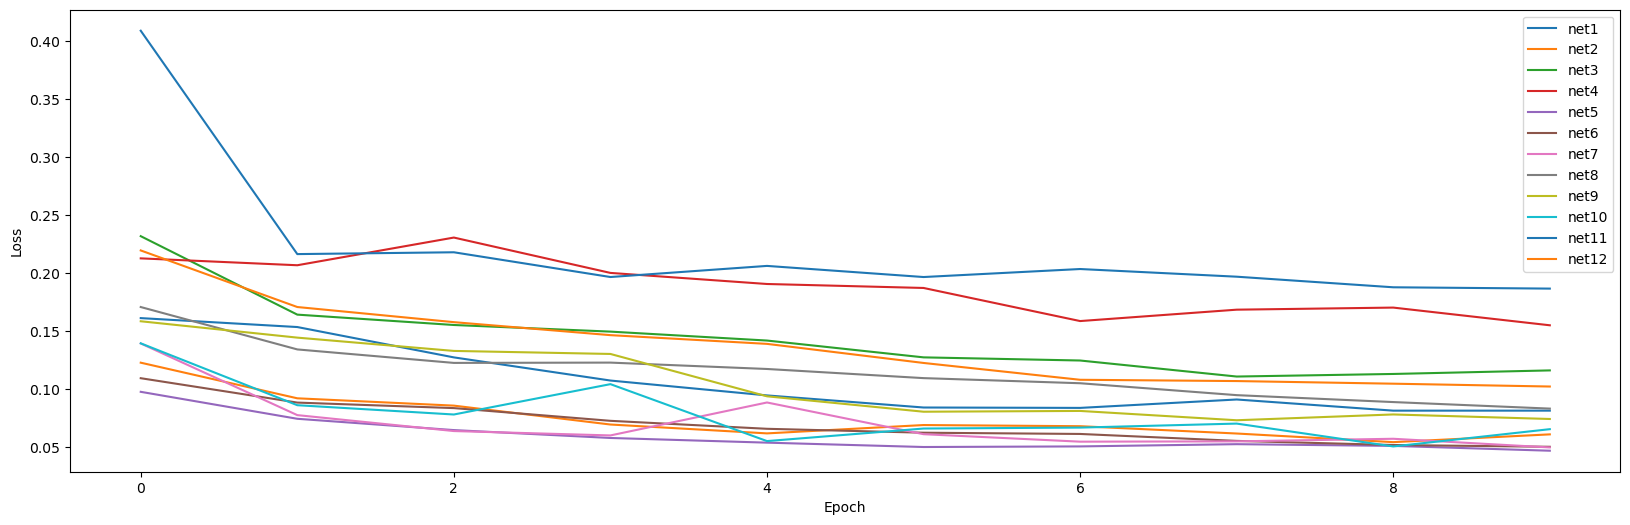

Results after 10 epochs:

Position 1: net5 - loss = 0.047
Position 2: net7 - loss = 0.05
Position 3: net6 - loss = 0.051
Position 4: net2 - loss = 0.061
Position 5: net10 - loss = 0.066
Position 6: net9 - loss = 0.074
Position 7: net1 - loss = 0.082
Position 8: net8 - loss = 0.083
Position 9: net12 - loss = 0.102
Position 10: net3 - loss = 0.116
Position 11: net4 - loss = 0.155
Position 12: net11 - loss = 0.187


In [39]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist1,label='net1')
plt.plot(loss_val_hist2,label='net2')
plt.plot(loss_val_hist3,label='net3')
plt.plot(loss_val_hist4,label='net4')
plt.plot(loss_val_hist5,label='net5')
plt.plot(loss_val_hist6,label='net6')
plt.plot(loss_val_hist7,label='net7')
plt.plot(loss_val_hist8,label='net8')
plt.plot(loss_val_hist9,label='net9')
plt.plot(loss_val_hist10,label='net10')
plt.plot(loss_val_hist11,label='net11')
plt.plot(loss_val_hist12,label='net12')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,13):
    
    loss_val = globals().get(f'loss_val_hist{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

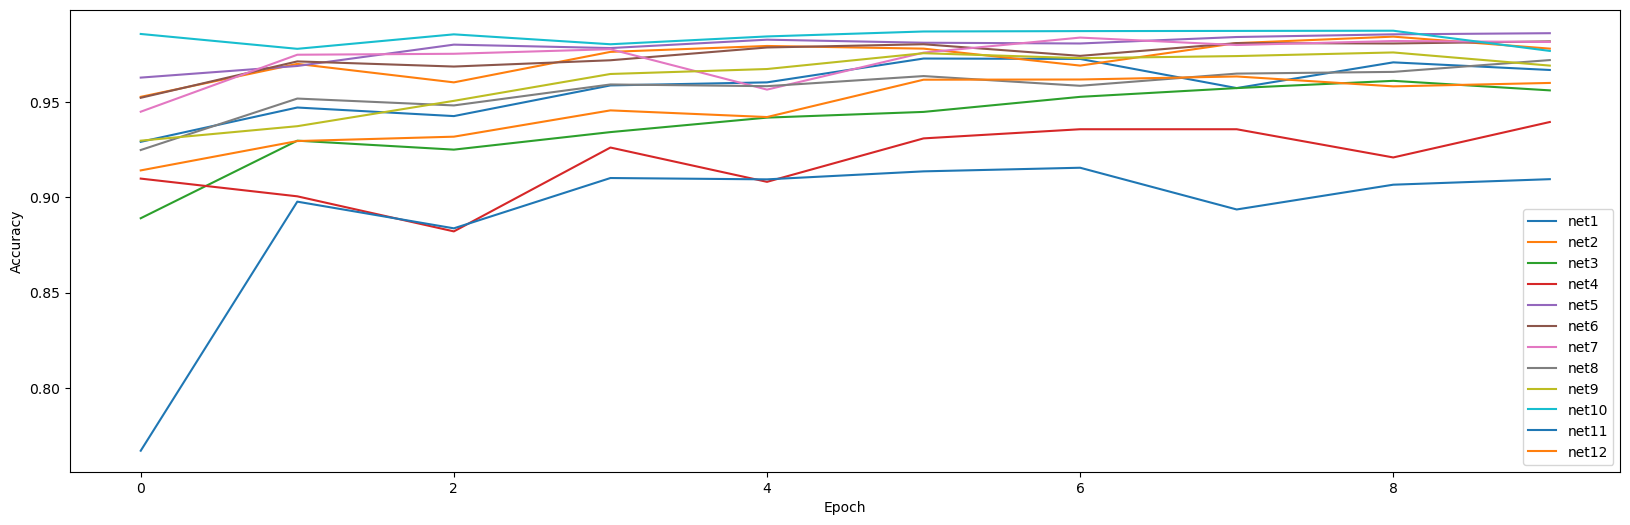

Results after 10 epochs:

Position 1: net5 - acc = 98.61%
Position 2: net6 - acc = 98.18%
Position 3: net7 - acc = 98.15%
Position 4: net2 - acc = 97.8%
Position 5: net10 - acc = 97.68%
Position 6: net8 - acc = 97.2%
Position 7: net9 - acc = 96.91%
Position 8: net1 - acc = 96.68%
Position 9: net12 - acc = 96.0%
Position 10: net3 - acc = 95.61%
Position 11: net4 - acc = 93.95%
Position 12: net11 - acc = 90.95%


In [59]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist1,label='net1')
plt.plot(acc_val_hist2,label='net2')
plt.plot(acc_val_hist3,label='net3')
plt.plot(acc_val_hist4,label='net4')
plt.plot(acc_val_hist5,label='net5')
plt.plot(acc_val_hist6,label='net6')
plt.plot(acc_val_hist7,label='net7')
plt.plot(acc_val_hist8,label='net8')
plt.plot(acc_val_hist9,label='net9')
plt.plot(acc_val_hist10,label='net10')
plt.plot(acc_val_hist11,label='net11')
plt.plot(acc_val_hist12,label='net12')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,13):
    
    acc_val = globals().get(f'acc_val_hist{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - acc = {round(acc_value*100,3)}%')

### Batch analysis

In [43]:
batch_size1 = 50
batch_size2 = 100
batch_size3 = 2000
nw=0

train_loader1 = DataLoader(train_dataset, batch_size=batch_size1, shuffle=True, num_workers=nw)
test_loader1  = DataLoader(test_dataset,  batch_size=batch_size1, shuffle=False, num_workers=nw)
val_loader1   = DataLoader(val_dataset,   batch_size=batch_size1, shuffle=False, num_workers=nw)

train_loader2 = DataLoader(train_dataset, batch_size=batch_size2, shuffle=True, num_workers=nw)
test_loader2  = DataLoader(test_dataset,  batch_size=batch_size2, shuffle=False, num_workers=nw)
val_loader2   = DataLoader(val_dataset,   batch_size=batch_size2, shuffle=False, num_workers=nw)

train_loader3 = DataLoader(train_dataset, batch_size=batch_size3, shuffle=True, num_workers=nw)
test_loader3  = DataLoader(test_dataset,  batch_size=batch_size3, shuffle=False, num_workers=nw)
val_loader3   = DataLoader(val_dataset,   batch_size=batch_size3, shuffle=False, num_workers=nw)

#### Net7

In [44]:
net7_batch1 = Net3layers(num_inputs2, num_hidden2, num_outputs_chamber2, num_steps2,True,alpha2,beta2,threshold2).to(device)


loss_fn7_batch1 = SF.ce_count_loss()
optimizer7_batch1 = torch.optim.Adam(net7_batch1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7_batch1, loss_val_hist7_batch1, acc_val_hist7_batch1 = train_net(net7_batch1,
                                                   train_loader1, val_loader1,
                                                   num_epochs, loss_fn7_batch1, optimizer7_batch1,
                                                   accuracy_type, batch_size1)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 3.963205575942993 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6627563238143921 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.47954562306404114 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.4391479194164276 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.3593268096446991 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.2912745475769043 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.2944179177284241 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.3071722686290741 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.232478067278862 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.08348331600427628 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.10374010354280472 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.13727086782455444 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.07873065024614334 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.26780909299850464 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.08653879910707474 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.2951882481575012 

Epoch: 0


Epoch: 3
Batch: 100
Iteration: 6100
Loss: 0.0028312457725405693 

Epoch: 3
Batch: 150
Iteration: 6150
Loss: 0.12313491106033325 

Epoch: 3
Batch: 200
Iteration: 6200
Loss: 0.018268773332238197 

Epoch: 3
Batch: 250
Iteration: 6250
Loss: 0.029382629320025444 

Epoch: 3
Batch: 300
Iteration: 6300
Loss: 0.043838758021593094 

Epoch: 3
Batch: 350
Iteration: 6350
Loss: 0.03503730893135071 

Epoch: 3
Batch: 400
Iteration: 6400
Loss: 0.0772949755191803 

Epoch: 3
Batch: 450
Iteration: 6450
Loss: 0.07251593470573425 

Epoch: 3
Batch: 500
Iteration: 6500
Loss: 0.05199873819947243 

Epoch: 3
Batch: 550
Iteration: 6550
Loss: 0.007358883507549763 

Epoch: 3
Batch: 600
Iteration: 6600
Loss: 0.017597174271941185 

Epoch: 3
Batch: 650
Iteration: 6650
Loss: 0.031227411702275276 

Epoch: 3
Batch: 700
Iteration: 6700
Loss: 0.05839303880929947 

Epoch: 3
Batch: 750
Iteration: 6750
Loss: 0.015592829324305058 

Epoch: 3
Batch: 800
Iteration: 6800
Loss: 0.035761862993240356 

Epoch: 3
Batch: 850
Iteration: 

Epoch: 6
Batch: 150
Iteration: 12150
Loss: 0.10499534755945206 

Epoch: 6
Batch: 200
Iteration: 12200
Loss: 0.06980638206005096 

Epoch: 6
Batch: 250
Iteration: 12250
Loss: 0.06981046497821808 

Epoch: 6
Batch: 300
Iteration: 12300
Loss: 0.02215561456978321 

Epoch: 6
Batch: 350
Iteration: 12350
Loss: 0.05762815475463867 

Epoch: 6
Batch: 400
Iteration: 12400
Loss: 0.04939975216984749 

Epoch: 6
Batch: 450
Iteration: 12450
Loss: 0.048795849084854126 

Epoch: 6
Batch: 500
Iteration: 12500
Loss: 0.017176922410726547 

Epoch: 6
Batch: 550
Iteration: 12550
Loss: 0.01913665235042572 

Epoch: 6
Batch: 600
Iteration: 12600
Loss: 0.020056258887052536 

Epoch: 6
Batch: 650
Iteration: 12650
Loss: 0.0991235002875328 

Epoch: 6
Batch: 700
Iteration: 12700
Loss: 0.003841692814603448 

Epoch: 6
Batch: 750
Iteration: 12750
Loss: 0.08187814801931381 

Epoch: 6
Batch: 800
Iteration: 12800
Loss: 0.11713103950023651 

Epoch: 6
Batch: 850
Iteration: 12850
Loss: 0.007171768695116043 

Epoch: 6
Batch: 900
I

Epoch: 9
Batch: 150
Iteration: 18150
Loss: 0.0428730770945549 

Epoch: 9
Batch: 200
Iteration: 18200
Loss: 0.048924971371889114 

Epoch: 9
Batch: 250
Iteration: 18250
Loss: 0.0230378620326519 

Epoch: 9
Batch: 300
Iteration: 18300
Loss: 0.07857080549001694 

Epoch: 9
Batch: 350
Iteration: 18350
Loss: 0.02414979413151741 

Epoch: 9
Batch: 400
Iteration: 18400
Loss: 0.04636775329709053 

Epoch: 9
Batch: 450
Iteration: 18450
Loss: 0.0833541750907898 

Epoch: 9
Batch: 500
Iteration: 18500
Loss: 0.12576790153980255 

Epoch: 9
Batch: 550
Iteration: 18550
Loss: 0.024382183328270912 

Epoch: 9
Batch: 600
Iteration: 18600
Loss: 0.019703451544046402 

Epoch: 9
Batch: 650
Iteration: 18650
Loss: 0.014950557611882687 

Epoch: 9
Batch: 700
Iteration: 18700
Loss: 0.07505039870738983 

Epoch: 9
Batch: 750
Iteration: 18750
Loss: 0.06509413570165634 

Epoch: 9
Batch: 800
Iteration: 18800
Loss: 0.08407970517873764 

Epoch: 9
Batch: 850
Iteration: 18850
Loss: 0.06400706619024277 

Epoch: 9
Batch: 900
Iter

In [45]:
net7_batch2 = Net3layers(num_inputs2, num_hidden2, num_outputs_chamber2, num_steps2,True,alpha2,beta2,threshold2).to(device)

loss_fn7_batch2 = SF.ce_count_loss()
optimizer7_batch2 = torch.optim.Adam(net7_batch2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7_batch2, loss_val_hist7_batch2, acc_val_hist7_batch2 = train_net(net7_batch2,
                                                   train_loader2, val_loader2,
                                                   num_epochs, loss_fn7_batch2, optimizer7_batch2,
                                                   accuracy_type, batch_size2)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 8.130000114440918 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.5980128049850464 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.31521859765052795 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.19993773102760315 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.09572876244783401 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.21185818314552307 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.18714766204357147 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.1650465428829193 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.1051594614982605 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.12278106808662415 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.145325168967247 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.17609825730323792 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.08535698056221008 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.09605056047439575 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.17160125076770782 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.23300935328006744 

Epoch

Validation Set Loss: 0.05827312916517258
Validation Set Accuracy: 98.35%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.024621378630399704 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.040892910212278366 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.03902358189225197 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.07332191616296768 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.10326200723648071 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.13247093558311462 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.027186589315533638 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.02918257936835289 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.04828723892569542 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.06716123223304749 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.10517922043800354 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.04615675285458565 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 0.07924249768257141 

Epoch: 6
Batch: 650
Iteration: 6650
Loss: 

In [46]:
net7_batch3 = Net3layers(num_inputs2, num_hidden2, num_outputs_chamber2, num_steps2,True,alpha2,beta2,threshold2).to(device)


loss_fn7_batch3 = SF.ce_count_loss()
optimizer7_batch3 = torch.optim.Adam(net7_batch3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist7_batch3, loss_val_hist7_batch3, acc_val_hist7_batch3 = train_net(net7_batch3,
                                                   train_loader3, val_loader3,
                                                   num_epochs, loss_fn7_batch3, optimizer7_batch3,
                                                   accuracy_type, batch_size3)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.9376749992370605 

Validation Set Loss: 0.6931473016738892
Validation Set Accuracy: 30.81%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 50
Loss: 0.6931473016738892 

Validation Set Loss: 0.6610032081604004
Validation Set Accuracy: 40.32%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 100
Loss: 0.6628859043121338 

Validation Set Loss: 0.3593410849571228
Validation Set Accuracy: 90.01%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 150
Loss: 0.3456747233867645 

Validation Set Loss: 0.32175562977790834
Validation Set Accuracy: 92.97%

--------------------------------------------------

Epoch: 4
Batch: 0
Iteration: 200
Loss: 0.31489792466163635 

Validation Set Loss: 0.3000469088554382
Validation Set Accuracy: 95.00%

--------------------------------------------------

Epoch: 5
Batch: 0
Iteration: 250
Loss: 0.2854757606983185 

Validation Set L

In [47]:
for i in range(1,4):
    csv_file_path = f'results/batch_test/output_net7_{i}.csv'
    
    loss_train = globals().get(f'loss_hist7_batch{i}')
    loss_val = globals().get(f'loss_val_hist7_batch{i}')
    acc = globals().get(f'acc_val_hist7_batch{i}')
    
    # Find the maximum length among the arrays
    max_length = max(len(loss_train), len(loss_val), len(acc))

    # Fill missing values with None
    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    # Write the data to a CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        # Write the header
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        # Write the data
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')

CSV file "results/batch_test/output_net7_1.csv" created successfully.
CSV file "results/batch_test/output_net7_2.csv" created successfully.
CSV file "results/batch_test/output_net7_3.csv" created successfully.


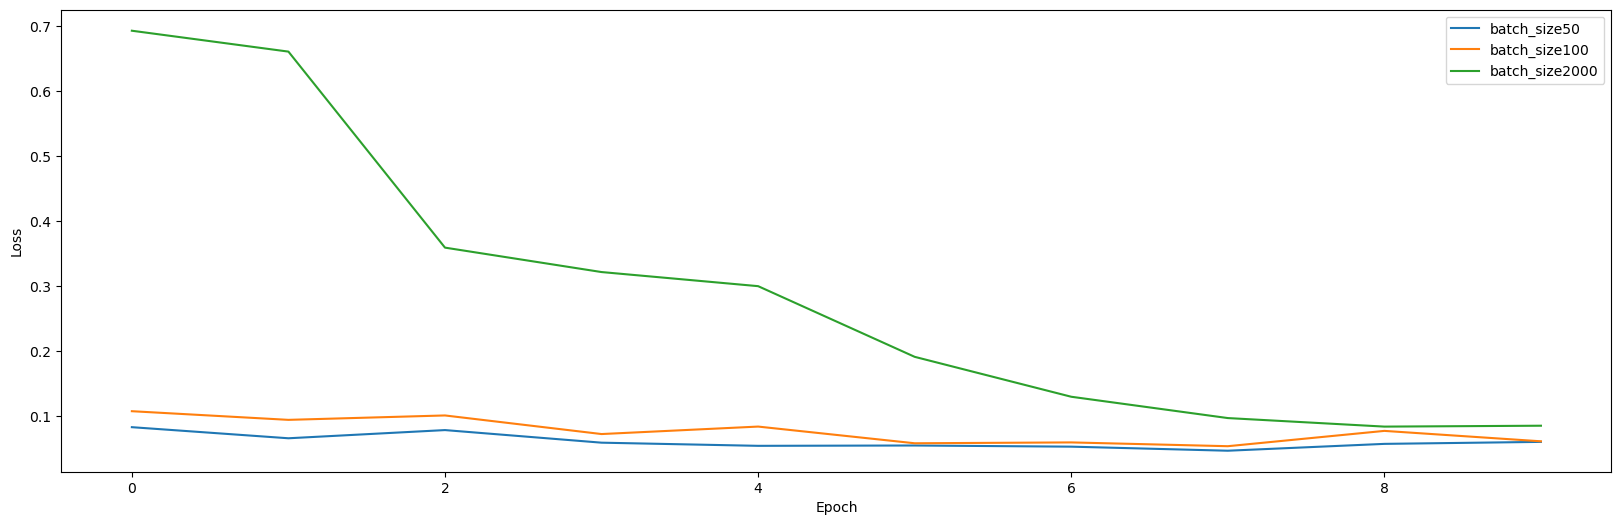

Results after 10 epochs:

Position 1: net1 - loss = 0.06
Position 2: net2 - loss = 0.061
Position 3: net3 - loss = 0.085


In [48]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist7_batch1,label='batch_size50')
plt.plot(loss_val_hist7_batch2,label='batch_size100')
plt.plot(loss_val_hist7_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,4):
    
    loss_val = globals().get(f'loss_val_hist7_batch{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

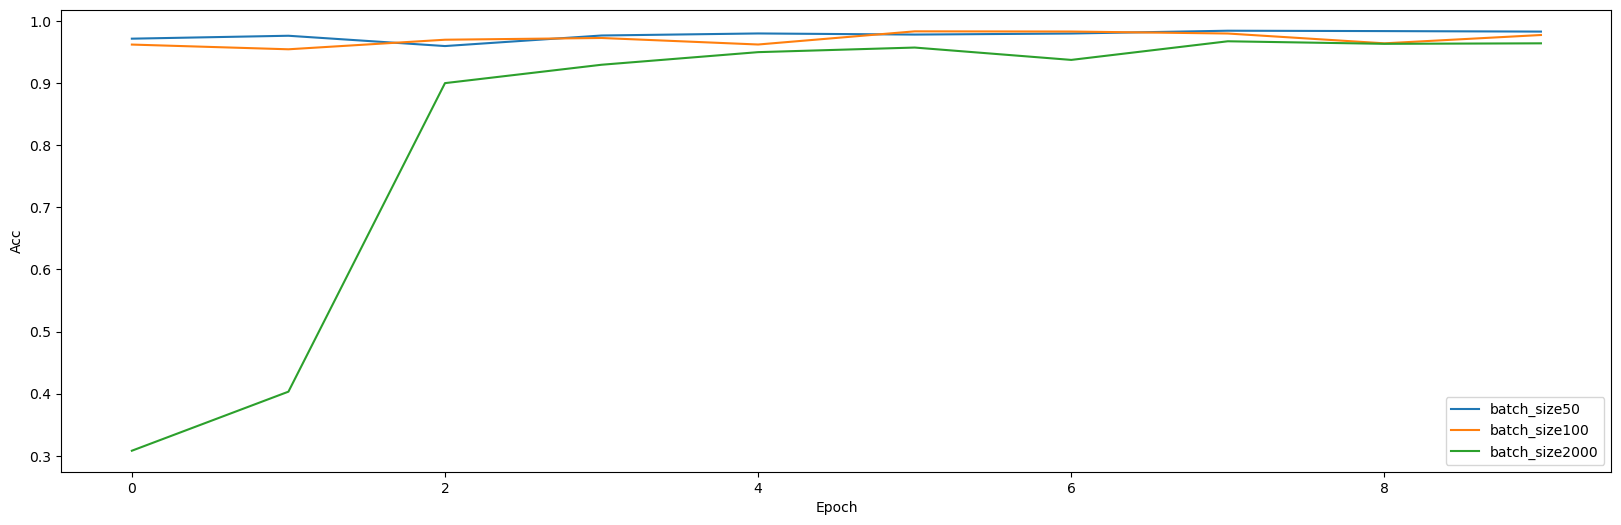

Results after 10 epochs:

Position 1: net1 - loss = 98.31%
Position 2: net2 - loss = 97.76%
Position 3: net3 - loss = 96.42%


In [49]:
# Plot Acc
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist7_batch1,label='batch_size50')
plt.plot(acc_val_hist7_batch2,label='batch_size100')
plt.plot(acc_val_hist7_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,4):
    
    acc_val = globals().get(f'acc_val_hist7_batch{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(acc_value*100,3)}%')

#### Net10

In [50]:
net10_batch1 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_chamber5, num_steps5,True,alpha5,beta5,threshold5).to(device)

loss_fn10 = SF.ce_count_loss()
optimizer10 = torch.optim.Adam(net10.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10, loss_val_hist10, acc_val_hist10 = train_net(net10,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn10, optimizer10,
                                                   accuracy_type, batch_size)

loss_fn10_batch1 = SF.ce_count_loss()
optimizer10_batch1 = torch.optim.Adam(net10_batch1.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10_batch1, loss_val_hist10_batch1, acc_val_hist10_batch1 = train_net(net10_batch1,
                                                   train_loader1, val_loader1,
                                                   num_epochs, loss_fn10_batch1, optimizer10_batch1,
                                                   accuracy_type, batch_size1)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.13951076567173004 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.06431378424167633 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.010564582422375679 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.045244961977005005 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.0393659844994545 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.12076625972986221 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.014279777184128761 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.13008886575698853 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.10910837352275848 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.13459962606430054 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.06575961410999298 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.10101605206727982 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.013056516647338867 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.04099440202116966 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.09171180427074432 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.016167404130101

Epoch: 5
Batch: 950
Iteration: 5950
Loss: 0.021345876157283783 

Validation Set Loss: 0.0479342157789506
Validation Set Accuracy: 98.70%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.02767016366124153 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.006691879127174616 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.013634856790304184 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.09312284737825394 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.03252727910876274 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.019298143684864044 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.031017232686281204 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.031256455928087234 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.032374631613492966 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.04407033324241638 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.0054580033756792545 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.09284801781177521 

Epoch: 6
Batch: 600
Iteration: 6600
L

Epoch: 0
Batch: 1850
Iteration: 1850
Loss: 0.04593605920672417 

Epoch: 0
Batch: 1900
Iteration: 1900
Loss: 0.016137177124619484 

Epoch: 0
Batch: 1950
Iteration: 1950
Loss: 0.04100024700164795 

Validation Set Loss: 0.09781554737128317
Validation Set Accuracy: 94.40%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 2000
Loss: 0.0951019674539566 

Epoch: 1
Batch: 50
Iteration: 2050
Loss: 0.017976632341742516 

Epoch: 1
Batch: 100
Iteration: 2100
Loss: 0.06750081479549408 

Epoch: 1
Batch: 150
Iteration: 2150
Loss: 0.09522897750139236 

Epoch: 1
Batch: 200
Iteration: 2200
Loss: 0.11047956347465515 

Epoch: 1
Batch: 250
Iteration: 2250
Loss: 0.09671833366155624 

Epoch: 1
Batch: 300
Iteration: 2300
Loss: 0.04005812481045723 

Epoch: 1
Batch: 350
Iteration: 2350
Loss: 0.0590401254594326 

Epoch: 1
Batch: 400
Iteration: 2400
Loss: 0.06899330765008926 

Epoch: 1
Batch: 450
Iteration: 2450
Loss: 0.12974059581756592 

Epoch: 1
Batch: 500
Iteration: 2500
Loss: 

Epoch: 3
Batch: 1900
Iteration: 7900
Loss: 0.039991192519664764 

Epoch: 3
Batch: 1950
Iteration: 7950
Loss: 0.19124309718608856 

Validation Set Loss: 0.05463438046746887
Validation Set Accuracy: 98.50%

--------------------------------------------------

Epoch: 4
Batch: 0
Iteration: 8000
Loss: 0.25498446822166443 

Epoch: 4
Batch: 50
Iteration: 8050
Loss: 0.044870030134916306 

Epoch: 4
Batch: 100
Iteration: 8100
Loss: 0.0793377235531807 

Epoch: 4
Batch: 150
Iteration: 8150
Loss: 0.32878658175468445 

Epoch: 4
Batch: 200
Iteration: 8200
Loss: 0.012951916083693504 

Epoch: 4
Batch: 250
Iteration: 8250
Loss: 0.10081086307764053 

Epoch: 4
Batch: 300
Iteration: 8300
Loss: 0.033977385610342026 

Epoch: 4
Batch: 350
Iteration: 8350
Loss: 0.04335521161556244 

Epoch: 4
Batch: 400
Iteration: 8400
Loss: 0.00689619779586792 

Epoch: 4
Batch: 450
Iteration: 8450
Loss: 0.030357657000422478 

Epoch: 4
Batch: 500
Iteration: 8500
Loss: 0.021115509793162346 

Epoch: 4
Batch: 550
Iteration: 8550
Lo

Epoch: 6
Batch: 1900
Iteration: 13900
Loss: 0.021303201094269753 

Epoch: 6
Batch: 1950
Iteration: 13950
Loss: 0.0040646689012646675 

Validation Set Loss: 0.04820552648423473
Validation Set Accuracy: 98.67%

--------------------------------------------------

Epoch: 7
Batch: 0
Iteration: 14000
Loss: 0.08925893902778625 

Epoch: 7
Batch: 50
Iteration: 14050
Loss: 0.013621874153614044 

Epoch: 7
Batch: 100
Iteration: 14100
Loss: 0.030409257858991623 

Epoch: 7
Batch: 150
Iteration: 14150
Loss: 0.08812198787927628 

Epoch: 7
Batch: 200
Iteration: 14200
Loss: 0.019563911482691765 

Epoch: 7
Batch: 250
Iteration: 14250
Loss: 0.007013251073658466 

Epoch: 7
Batch: 300
Iteration: 14300
Loss: 0.022259516641497612 

Epoch: 7
Batch: 350
Iteration: 14350
Loss: 0.041219014674425125 

Epoch: 7
Batch: 400
Iteration: 14400
Loss: 0.002086838474497199 

Epoch: 7
Batch: 450
Iteration: 14450
Loss: 0.02339419163763523 

Epoch: 7
Batch: 500
Iteration: 14500
Loss: 0.015636883676052094 

Epoch: 7
Batch: 550

Epoch: 9
Batch: 1850
Iteration: 19850
Loss: 0.04718494042754173 

Epoch: 9
Batch: 1900
Iteration: 19900
Loss: 0.03828255832195282 

Epoch: 9
Batch: 1950
Iteration: 19950
Loss: 0.005680265836417675 

Validation Set Loss: 0.051171872003469614
Validation Set Accuracy: 97.67%

--------------------------------------------------



In [51]:
net10_batch2 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_chamber5, num_steps5,True,alpha5,beta5,threshold5).to(device)

loss_fn10_batch2 = SF.ce_count_loss()
optimizer10_batch2 = torch.optim.Adam(net10_batch2.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10_batch2, loss_val_hist10_batch2, acc_val_hist10_batch2 = train_net(net10_batch2,
                                                   train_loader2, val_loader2,
                                                   num_epochs, loss_fn10_batch2, optimizer10_batch2,
                                                   accuracy_type, batch_size2)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 6.53000020980835 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 0.6931473016738892 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 0.6931473016738892 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 0.6931473016738892 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.6931473016738892 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.6093606352806091 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.3579838275909424 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.33554866909980774 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.33115360140800476 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.33901524543762207 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.41467607021331787 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 0.3270031213760376 

Epoch: 0
Batch: 600
Iteration: 600
Loss: 0.23358501493930817 

Epoch: 0
Batch: 650
Iteration: 650
Loss: 0.2710323631763458 

Epoch: 0
Batch: 700
Iteration: 700
Loss: 0.19883641600608826 

Epoch: 0
Batch: 750
Iteration: 750
Loss: 0.17699389159679413 

Epoch: 0


Epoch: 5
Batch: 950
Iteration: 5950
Loss: 0.22260455787181854 

Validation Set Loss: 0.05476568533107638
Validation Set Accuracy: 98.39%

--------------------------------------------------

Epoch: 6
Batch: 0
Iteration: 6000
Loss: 0.01638631522655487 

Epoch: 6
Batch: 50
Iteration: 6050
Loss: 0.008404148742556572 

Epoch: 6
Batch: 100
Iteration: 6100
Loss: 0.12238632142543793 

Epoch: 6
Batch: 150
Iteration: 6150
Loss: 0.022645704448223114 

Epoch: 6
Batch: 200
Iteration: 6200
Loss: 0.030558690428733826 

Epoch: 6
Batch: 250
Iteration: 6250
Loss: 0.012213146314024925 

Epoch: 6
Batch: 300
Iteration: 6300
Loss: 0.20758594572544098 

Epoch: 6
Batch: 350
Iteration: 6350
Loss: 0.03356149047613144 

Epoch: 6
Batch: 400
Iteration: 6400
Loss: 0.05526354908943176 

Epoch: 6
Batch: 450
Iteration: 6450
Loss: 0.08699344843626022 

Epoch: 6
Batch: 500
Iteration: 6500
Loss: 0.0712769404053688 

Epoch: 6
Batch: 550
Iteration: 6550
Loss: 0.06262429058551788 

Epoch: 6
Batch: 600
Iteration: 6600
Loss: 

In [52]:
net10_batch3 = Net1layer2ndOrder(num_inputs5, num_hidden5, num_outputs_chamber5, num_steps5,True,alpha5,beta5,threshold5).to(device)

loss_fn10_batch3 = SF.ce_count_loss()
optimizer10_batch3 = torch.optim.Adam(net10_batch3.parameters(), lr=5e-4, betas=(0.9, 0.999))

loss_hist10_batch3, loss_val_hist10_batch3, acc_val_hist10_batch3 = train_net(net10,
                                                   train_loader3, val_loader3,
                                                   num_epochs, loss_fn10_batch3, optimizer10_batch3,
                                                   accuracy_type, batch_size3)

Epoch: 0
Batch: 0
Iteration: 0
Loss: 0.048339489847421646 

Validation Set Loss: 0.052726855129003526
Validation Set Accuracy: 97.68%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 50
Loss: 0.04933558776974678 

Validation Set Loss: 0.052726855129003526
Validation Set Accuracy: 97.68%

--------------------------------------------------

Epoch: 2
Batch: 0
Iteration: 100
Loss: 0.0542968288064003 

Validation Set Loss: 0.052726855129003526
Validation Set Accuracy: 97.68%

--------------------------------------------------

Epoch: 3
Batch: 0
Iteration: 150
Loss: 0.06240452826023102 

Validation Set Loss: 0.052726855129003526
Validation Set Accuracy: 97.68%

--------------------------------------------------

Epoch: 4
Batch: 0
Iteration: 200
Loss: 0.03985002264380455 

Validation Set Loss: 0.052726855129003526
Validation Set Accuracy: 97.68%

--------------------------------------------------

Epoch: 5
Batch: 0
Iteration: 250
Loss: 0.05440063029527664 

Va

In [58]:
import torch

# Assuming you have two tensors named tensor1 and tensor2
tensor1 = torch.rand(100, 100, 4, 4)
tensor2 = torch.rand(100, 100, 1, 4)

print(tensor1[0,0],tensor2[0,0])
# Sum along the third dimension (index 2)
result = tensor1 + tensor2
print(result[0,0])
# Verify the shape of the result
print(result.shape)


tensor([[0.6859, 0.5753, 0.2074, 0.4007],
        [0.9607, 0.6247, 0.3565, 0.9253],
        [0.1358, 0.1457, 0.7181, 0.3232],
        [0.5323, 0.7577, 0.3964, 0.3287]]) tensor([[0.3149, 0.3817, 0.8598, 0.2450]])
tensor([[1.0008, 0.9569, 1.0671, 0.6458],
        [1.2755, 1.0064, 1.2163, 1.1704],
        [0.4506, 0.5274, 1.5779, 0.5682],
        [0.8471, 1.1394, 1.2561, 0.5738]])
torch.Size([100, 100, 4, 4])


In [53]:
for i in range(1,4):
    csv_file_path = f'results/batch_test/output_net10_{i}.csv'
    
    loss_train = globals().get(f'loss_hist10_batch{i}')
    loss_val = globals().get(f'loss_val_hist10_batch{i}')
    acc = globals().get(f'acc_val_hist10_batch{i}')
    
    # Find the maximum length among the arrays
    max_length = max(len(loss_train), len(loss_val), len(acc))

    # Fill missing values with None
    loss_train += [None] * (max_length - len(loss_train))
    loss_val += [None] * (max_length - len(loss_val))
    acc += [None] * (max_length - len(acc))
    
    rows = list(zip(loss_train, loss_val, acc))
    
    # Write the data to a CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
    
        # Write the header
        writer.writerow(['LossTrain', 'LossVal', 'Accuracy'])
    
        # Write the data
        writer.writerows(rows)

    print(f'CSV file "{csv_file_path}" created successfully.')

CSV file "results/batch_test/output_net10_1.csv" created successfully.
CSV file "results/batch_test/output_net10_2.csv" created successfully.
CSV file "results/batch_test/output_net10_3.csv" created successfully.


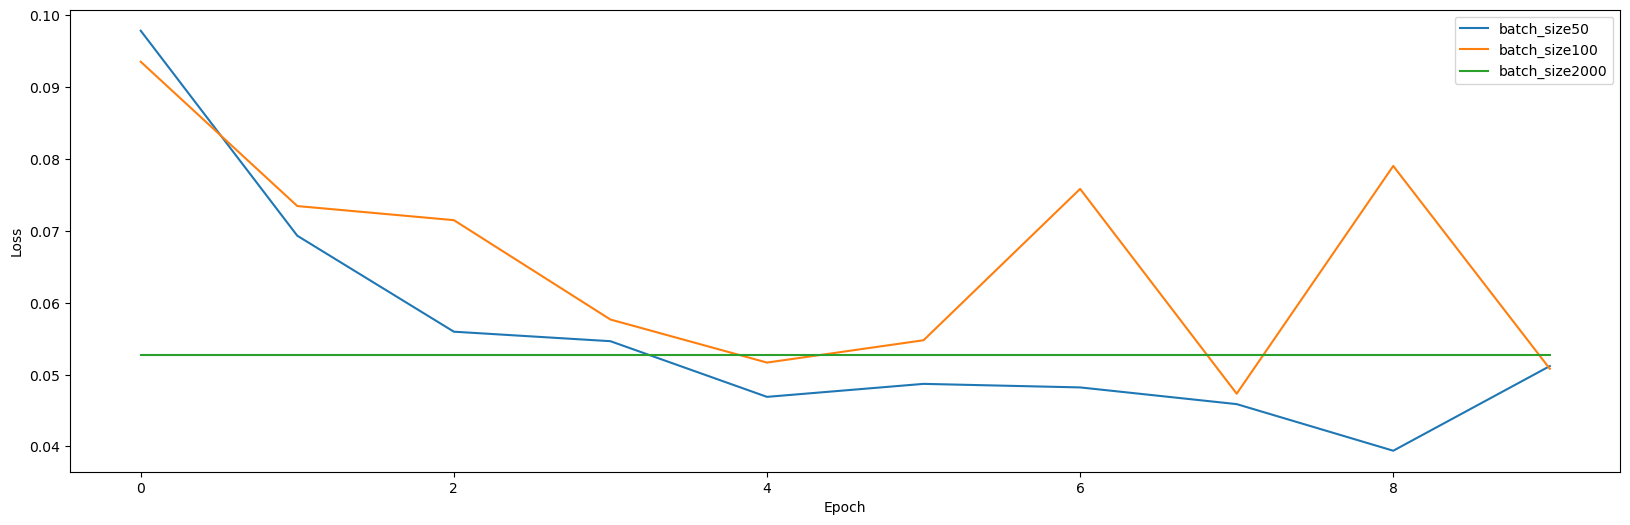

Results after 10 epochs:

Position 1: net2 - loss = 0.051
Position 2: net1 - loss = 0.051
Position 3: net3 - loss = 0.053


In [54]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_val_hist10_batch1,label='batch_size50')
plt.plot(loss_val_hist10_batch2,label='batch_size100')
plt.plot(loss_val_hist10_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

last_loss_values = []
for i in range(1,4):
    
    loss_val = globals().get(f'loss_val_hist10_batch{i}')
    last_loss_val = [value for value in loss_val if value is not None][-1]
    last_loss_values.append(last_loss_val)

best_loss = np.argsort(last_loss_values)        

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_loss):
    loss_value = last_loss_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

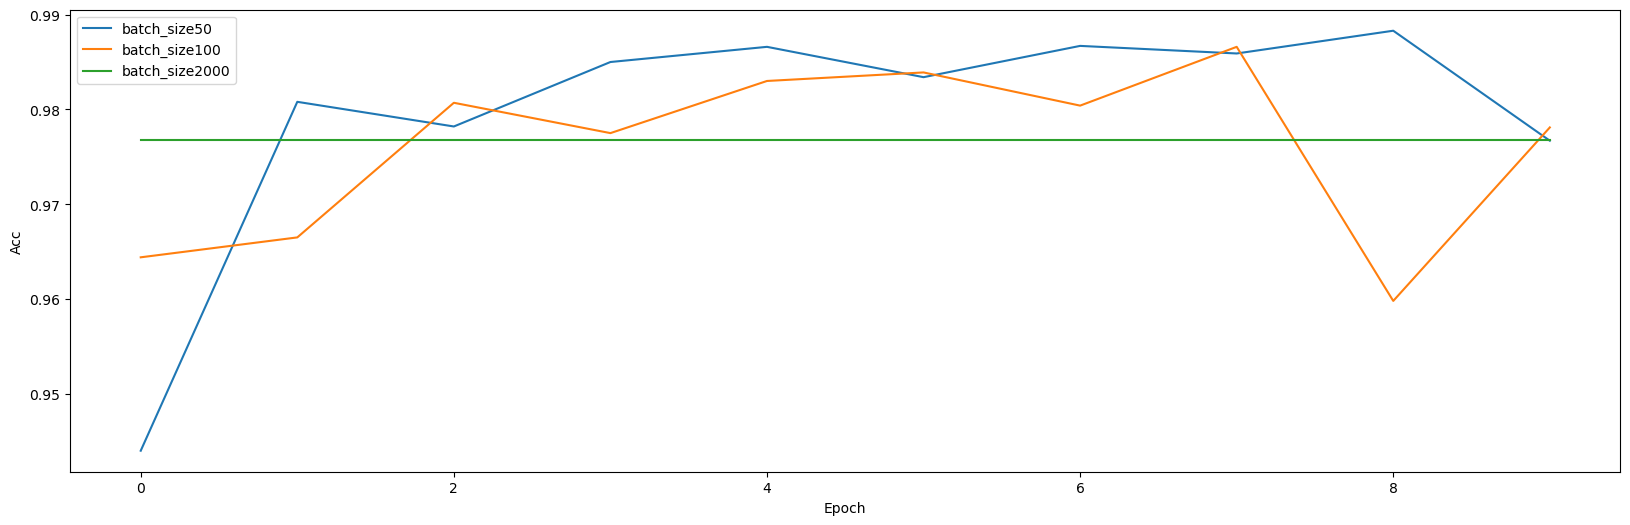

Results after 10 epochs:

Position 1: net2 - loss = 97.81%
Position 2: net3 - loss = 97.68%
Position 3: net1 - loss = 97.67%


In [55]:
# Plot Acc
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist10_batch1,label='batch_size50')
plt.plot(acc_val_hist10_batch2,label='batch_size100')
plt.plot(acc_val_hist10_batch3,label='batch_size2000')
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()
plt.show()

last_acc_values = []
for i in range(1,4):
    
    acc_val = globals().get(f'acc_val_hist10_batch{i}')
    last_acc_val = [value for value in acc_val if value is not None][-1]
    last_acc_values.append(last_acc_val)

best_acc = np.argsort(last_acc_values) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = last_acc_values[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(acc_value*100,3)}%')